In [8]:

# 📌 Parametros base
from pathlib import Path
from datetime import date

FECHA = date.today().isoformat()
DATA_DIR = Path("D:/trading/data")
FEATURES_DIR = DATA_DIR / "features"
BACKTEST_FILE = Path(f"D:/trading/reports/backtesting/bt_heuristicas_2025-05-27.csv")
OUTPUT_FILE = DATA_DIR / "train/XGBoost_buy_train001.csv"

# Listas definidas
estrategias_usar = ["macd_hist_reversal", "rsi_reversion", "ma_envelope_reversals"]
simbolos_usar = ["MORN", "COP", "C", "PSTG", "PRMB", "BAC", "BX", "IRM", "SYM", "OWL"]


In [9]:
# Cargar dataset original
df_bt_full = pd.read_csv(BACKTEST_FILE)
df_bt_full["fecha_entry"] = pd.to_datetime(df_bt_full["fecha_entry"], errors="coerce")
df_bt_full["fecha_exit"] = pd.to_datetime(df_bt_full["fecha_exit"], errors="coerce")

# Filtrar solo señales 'buy'
df_bt = df_bt_full[
    (df_bt_full["signal"] == "buy") &
    (df_bt_full["estrategia"].isin(estrategias_usar)) &
    (df_bt_full["simbolo"].isin(simbolos_usar))
].copy()
df_bt["simbolo"] = df_bt["simbolo"].str.upper()

# Confirmar columna 'exito'
df_bt["exito"] = df_bt["retorno"] > 0

In [12]:
# Unir features con señales de backtest (solo 'buy') usando pyarrow
import pandas as pd

df_final = []

for simbolo in simbolos_usar:
    try:
        feat_path = FEATURES_DIR / f"{simbolo}_features.parquet"
        if not feat_path.exists():
            print(f"Archivo no encontrado para {simbolo}: {feat_path.name}")
            continue

        df_feat = pd.read_parquet(feat_path, engine="pyarrow")

        if df_feat.empty:
            print(f"Archivo {feat_path.name} esta vacio")
            continue

        if "fecha" not in df_feat.columns:
            print(f"Archivo {feat_path.name} no contiene columna 'fecha'")
            continue

        df_feat["fecha"] = pd.to_datetime(df_feat["fecha"], errors="coerce")
        df_feat["simbolo"] = simbolo

        df_bt_sim = df_bt[df_bt["simbolo"] == simbolo].copy()
        df_bt_sim = df_bt_sim[["fecha_entry", "estrategia", "exit", "exito"]]
        df_bt_sim = df_bt_sim.rename(columns={"fecha_entry": "fecha"})
        df_bt_sim["simbolo"] = simbolo  # esta linea es clave

        merged = pd.merge(df_bt_sim, df_feat, on=["fecha", "simbolo"], how="inner")

        if merged.empty:
            print(f"Sin coincidencias en fechas para {simbolo}")
            continue

        print(f"{simbolo}: {len(merged)} filas fusionadas")
        df_final.append(merged)

    except Exception as e:
        print(f"Error con simbolo {simbolo}: {e}")

# Guardar dataset final
if df_final:
    df_merged = pd.concat(df_final, ignore_index=True)
    print(f"\nDataset final fusionado: {df_merged.shape}")
    df_merged.to_csv(OUTPUT_FILE, index=False)
    print(f"Archivo guardado en: {OUTPUT_FILE}")
else:
    print("\nNo se pudo construir el dataset. Revisa los errores anteriores.")



MORN: 2687 filas fusionadas
COP: 2970 filas fusionadas
C: 3090 filas fusionadas
PSTG: 1644 filas fusionadas
PRMB: 3299 filas fusionadas
BAC: 2982 filas fusionadas
BX: 2761 filas fusionadas
IRM: 2971 filas fusionadas
SYM: 730 filas fusionadas
OWL: 709 filas fusionadas

Dataset final fusionado: (23843, 20)
Archivo guardado en: D:\trading\data\train\XGBoost_buy_train001.csv


C:\Users\leant\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:27:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Matriz de confusion:
 [[2318  847]
 [1070 1726]]

Reporte de clasificacion:
               precision    recall  f1-score   support

           0       0.68      0.73      0.71      3165
           1       0.67      0.62      0.64      2796

    accuracy                           0.68      5961
   macro avg       0.68      0.67      0.68      5961
weighted avg       0.68      0.68      0.68      5961



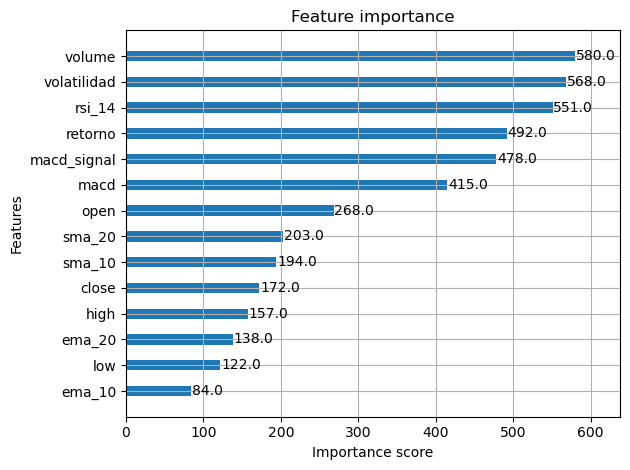

In [14]:
# Entrenamiento XGBoost - train001 (corregido)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt

# Cargar dataset
DATA_PATH = "D:/trading/data/train/XGBoost_buy_train001.csv"
df = pd.read_csv(DATA_PATH)

# Confirmar y eliminar columnas no numericas que no aportan
columnas_excluir = ["estrategia", "simbolo", "fecha", "fecha_exit", "exit"]
columnas_validas = df.drop(columns=columnas_excluir, errors="ignore").select_dtypes(include=["number", "bool"]).columns.tolist()

# Separar features y target
X = df[columnas_validas].drop(columns=["exito"], errors="ignore")
y = df["exito"].astype(int)

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Modelo
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train, y_train)

# Evaluacion
y_pred = model.predict(X_val)
print("Matriz de confusion:\n", confusion_matrix(y_val, y_pred))
print("\nReporte de clasificacion:\n", classification_report(y_val, y_pred))

# Importancia
xgb.plot_importance(model, max_num_features=15, height=0.4)
plt.tight_layout()
plt.show()


In [15]:
import joblib
from pathlib import Path

MODEL_PATH = Path("D:/trading/modelos/ml/xgboost_buy_train001.pkl")
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

joblib.dump(model, MODEL_PATH)
print(f"Modelo guardado en: {MODEL_PATH}")


Modelo guardado en: D:\trading\modelos\ml\xgboost_buy_train001.pkl
